<a href="https://colab.research.google.com/github/Parviz-Tafazzoli/Probabilistic-Models-for-FFP-Interpretation/blob/main/ANN_RandomSubsampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install Tensorflow==2.12.0

In [ ]:
!pip uninstall pandas

Found existing installation: pandas 2.2.3
Uninstalling pandas-2.2.3:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/pandas-2.2.3.dist-info/*
    /usr/local/lib/python3.10/dist-packages/pandas/*
Proceed (Y/n)? Y
  Successfully uninstalled pandas-2.2.3


In [ ]:
!pip install pandas

  Using cached pandas-2.2.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
Using cached pandas-2.2.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.22.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 2.2.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
xarray 2024.9.0 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/My Drive/Objective1/ANN/NewTrainingData2.xlsx'
data = pd.read_excel(file_path)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/Objective1/ANN/NewTrainingData2.xlsx'

In [ ]:
# Assuming data is pre-loaded into `data`
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Initialize lists to store metrics and predictions across iterations
train_metrics = []
test_metrics = []
train_actual_pred = []
test_actual_pred = []
loss_history = []

# Number of iterations for random subsampling
num_iterations = 3

# Start overall timer
overall_start_time = time.time()

for i in range(num_iterations):
    # Start timer for each iteration
    iteration_start_time = time.time()

    # Split data into 85% training+validation and 15% testing
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=None)

    # Split the 85% training+validation data into 70% training and 15% validation
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=None)

    # Normalize the inputs using StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Define the MLP model
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(X_train_scaled.shape[1],)),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dense(1)  # Output layer
    ])

    # Compile the model with a custom learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    # Train the model
    history = model.fit(
        X_train_scaled,
        y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=6000,
        verbose=0
    )

    # Store loss history
    loss_history.append(history.history)

    # Get predictions for training and testing data
    y_train_pred = model.predict(X_train_scaled, verbose=0)
    y_test_pred = model.predict(X_test_scaled, verbose=0)

    # Calculate metrics for training data
    train_r2 = r2_score(y_train, y_train_pred)
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

    # Calculate metrics for testing data
    test_r2 = r2_score(y_test, y_test_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # Append metrics to the respective lists
    train_metrics.append([train_r2, train_mape, train_mae, train_rmse])
    test_metrics.append([test_r2, test_mape, test_mae, test_rmse])

    # Append actual vs predicted for both training and testing data
    train_actual_pred.append(pd.DataFrame({'Actual': y_train.flatten(), 'Predicted': y_train_pred.flatten()}))
    test_actual_pred.append(pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_test_pred.flatten()}))

    # End timer for the current iteration
    iteration_end_time = time.time()
    iteration_time = iteration_end_time - iteration_start_time
    print(f"Iteration {i+1}/{num_iterations} completed in {iteration_time:.2f} seconds.")

# End overall timer
overall_end_time = time.time()
total_time = overall_end_time - overall_start_time
avg_iteration_time = total_time / num_iterations

# Print overall time estimates
print(f"Average time per iteration: {avg_iteration_time:.2f} seconds")
print(f"Total runtime: {total_time:.2f} seconds")

# Save metrics to the first Excel file
metrics_df = pd.DataFrame(train_metrics, columns=['Train R2', 'Train MAPE', 'Train MAE', 'Train RMSE'])
metrics_df[['Test R2', 'Test MAPE', 'Test MAE', 'Test RMSE']] = pd.DataFrame(test_metrics)
metrics_file = '/content/drive/My Drive/Objective1/ANN/metrics_ANN_new.xlsx'
metrics_df.to_excel(metrics_file, index=False)

# Save actual vs predicted values for training data in the second Excel file with separate sheets
train_actual_pred_file = '/content/drive/My Drive/Objective1/ANN/train_actual_vs_pred_ANN_new.xlsx'
with pd.ExcelWriter(train_actual_pred_file, engine='openpyxl') as writer:
    for i, df in enumerate(train_actual_pred):
        df.to_excel(writer, sheet_name=f'Iteration_{i+1}', index=False)

# Save actual vs predicted values for testing data in the third Excel file with separate sheets
test_actual_pred_file = '/content/drive/My Drive/Objective1/ANN/test_actual_vs_pred_ANN_new.xlsx'
with pd.ExcelWriter(test_actual_pred_file, engine='openpyxl') as writer:
    for i, df in enumerate(test_actual_pred):
        df.to_excel(writer, sheet_name=f'Iteration_{i+1}', index=False)

print(f'Metrics saved to: {metrics_file}')
print(f'Training actual vs predicted saved to: {train_actual_pred_file}')
print(f'Testing actual vs predicted saved to: {test_actual_pred_file}')

# Plot loss vs epochs for both training and validation across iterations
for i, history in enumerate(loss_history):
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Iteration {i+1} - Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


KeyboardInterrupt: 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Iteration 1/3 completed in 855.55 seconds.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Iteration 2/3 completed in 788.97 seconds.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Iteration 3/3 completed in 790.86 seconds.
Average time per iteration: 811.79 seconds
Total runtime: 2435.38 seconds
Metrics saved to: /content/drive/My Drive/Objective1/ANN/metrics_ANN_new.xlsx
Training actual vs predicted saved to: /content/drive/My Drive/Objective1/ANN/train_actual_vs_pred_ANN_new.xlsx
Testing actual vs predicted saved to: /content/drive/My Drive/Objective1/ANN/test_actual_vs_pred_ANN_new.xlsx


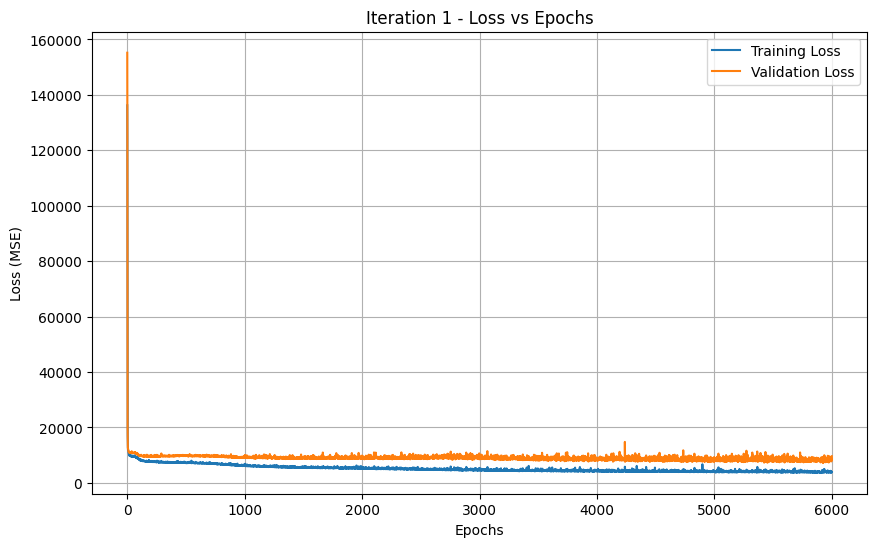

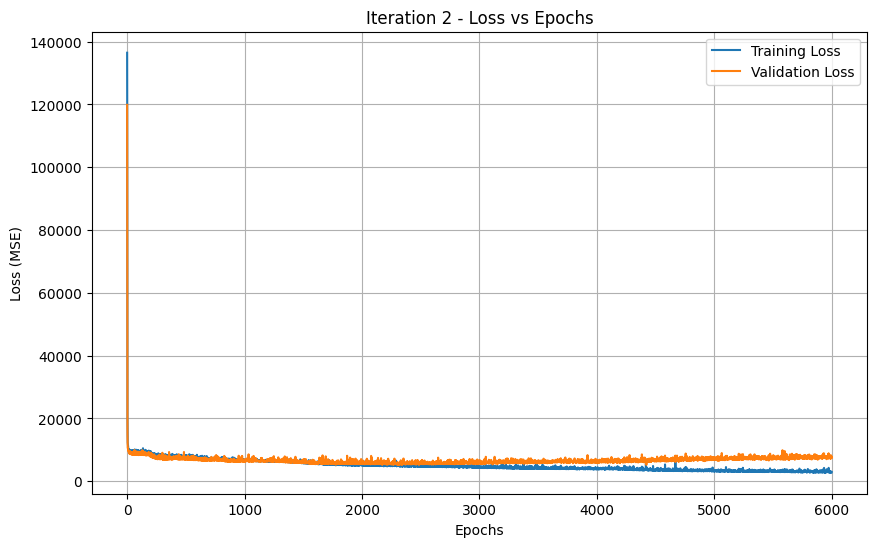

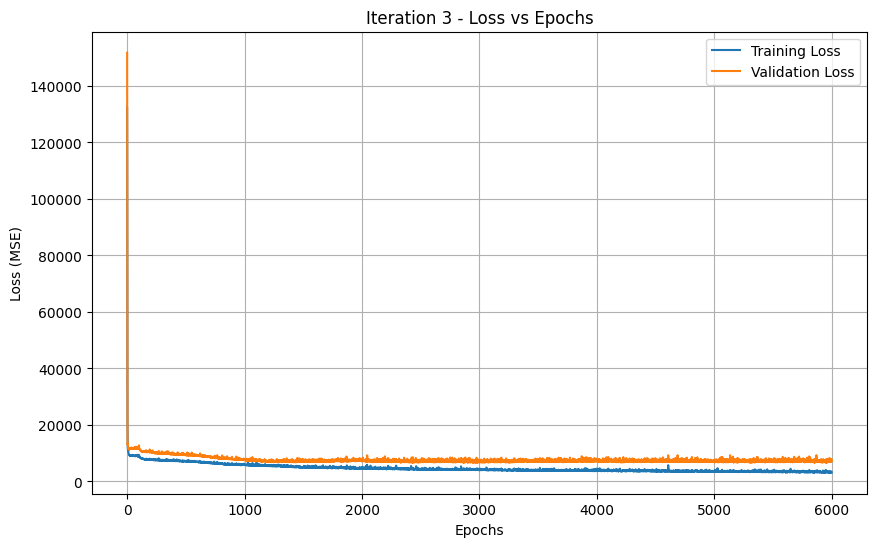

In [ ]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time



from google.colab import drive
drive.mount('/content/drive')



file_path = '/content/drive/My Drive/Objective1/ANN/NewTrainingData.xlsx'
data = pd.read_excel(file_path)



# Assuming data is pre-loaded into `data`
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Initialize lists to store metrics and predictions across iterations
train_metrics = []
test_metrics = []
train_actual_pred = []
test_actual_pred = []
loss_history = []

# Number of iterations for random subsampling
num_iterations = 3

# Start overall timer
overall_start_time = time.time()

for i in range(num_iterations):
    # Start timer for each iteration
    iteration_start_time = time.time()

    # Split data into 85% training+validation and 15% testing
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=None)

    # Split the 85% training+validation data into 70% training and 15% validation
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=None)

    # Normalize the inputs using StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Define the MLP model
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(X_train_scaled.shape[1],)),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dense(1)  # Output layer
    ])

    # Compile the model with a custom learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    # Train the model
    history = model.fit(
        X_train_scaled,
        y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=6000,
        verbose=0
    )

    # Store loss history
    loss_history.append(history.history)

    # Get predictions for training and testing data
    y_train_pred = model.predict(X_train_scaled, verbose=0)
    y_test_pred = model.predict(X_test_scaled, verbose=0)

    # Calculate metrics for training data
    train_r2 = r2_score(y_train, y_train_pred)
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

    # Calculate metrics for testing data
    test_r2 = r2_score(y_test, y_test_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # Append metrics to the respective lists
    train_metrics.append([train_r2, train_mape, train_mae, train_rmse])
    test_metrics.append([test_r2, test_mape, test_mae, test_rmse])

    # Append actual vs predicted for both training and testing data
    train_actual_pred.append(pd.DataFrame({'Actual': y_train.flatten(), 'Predicted': y_train_pred.flatten()}))
    test_actual_pred.append(pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_test_pred.flatten()}))

    # End timer for the current iteration
    iteration_end_time = time.time()
    iteration_time = iteration_end_time - iteration_start_time
    print(f"Iteration {i+1}/{num_iterations} completed in {iteration_time:.2f} seconds.")

# End overall timer
overall_end_time = time.time()
total_time = overall_end_time - overall_start_time
avg_iteration_time = total_time / num_iterations

# Print overall time estimates
print(f"Average time per iteration: {avg_iteration_time:.2f} seconds")
print(f"Total runtime: {total_time:.2f} seconds")

# Save metrics to the first Excel file
metrics_df = pd.DataFrame(train_metrics, columns=['Train R2', 'Train MAPE', 'Train MAE', 'Train RMSE'])
metrics_df[['Test R2', 'Test MAPE', 'Test MAE', 'Test RMSE']] = pd.DataFrame(test_metrics)
metrics_file = '/content/drive/My Drive/Objective1/ANN/metrics_ANN_new.xlsx'
metrics_df.to_excel(metrics_file, index=False)

# Save actual vs predicted values for training data in the second Excel file with separate sheets
train_actual_pred_file = '/content/drive/My Drive/Objective1/ANN/train_actual_vs_pred_ANN_new.xlsx'
with pd.ExcelWriter(train_actual_pred_file, engine='openpyxl') as writer:
    for i, df in enumerate(train_actual_pred):
        df.to_excel(writer, sheet_name=f'Iteration_{i+1}', index=False)

# Save actual vs predicted values for testing data in the third Excel file with separate sheets
test_actual_pred_file = '/content/drive/My Drive/Objective1/ANN/test_actual_vs_pred_ANN_new.xlsx'
with pd.ExcelWriter(test_actual_pred_file, engine='openpyxl') as writer:
    for i, df in enumerate(test_actual_pred):
        df.to_excel(writer, sheet_name=f'Iteration_{i+1}', index=False)

print(f'Metrics saved to: {metrics_file}')
print(f'Training actual vs predicted saved to: {train_actual_pred_file}')
print(f'Testing actual vs predicted saved to: {test_actual_pred_file}')

# Plot loss vs epochs for both training and validation across iterations
for i, history in enumerate(loss_history):
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Iteration {i+1} - Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
import io
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import os

# -------------------------------
# 1) Paths
# -------------------------------
train_path = '/content/drive/My Drive/Objective1/ANN/NewTrainingData2.xlsx'
val_path   = '/content/drive/My Drive/Objective1/ANN/Unisydney-Data.xlsx'
save_dir   = '/content/drive/My Drive/Objective1/ANN'
os.makedirs(save_dir, exist_ok=True)
predictions_path = os.path.join(save_dir, 'Unisydney_Validation_with_predictions.xlsx')

# -------------------------------
# 2) Load TRAINING data (last column = target)
# -------------------------------
data = pd.read_excel(train_path)
feature_cols = list(data.columns[:-1])
target_col   = data.columns[-1]

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# -------------------------------
# 3) Single random subsampling split (same logic as before)
# -------------------------------
# 85% train+val, 15% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=None
)

# Of the 85%, split into 70% train and 15% val (relative to the whole set)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=None
)

# -------------------------------
# 4) Scale features
# -------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# -------------------------------
# 5) Build SAME MLP architecture
#     [Dense(30,relu) -> Dense(20,relu) -> Dense(1)]
# -------------------------------
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(30, activation='relu'),
    layers.Dense(20, activation='relu'),
    layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Train for 6000 epochs (as in your script; no EarlyStopping)
start_time = time.time()
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=6000, verbose=0
)
print(f"Training finished in {time.time() - start_time:.2f} s.")

# -------------------------------
# 6) Evaluate on TEST set
# -------------------------------
y_test_pred = model.predict(X_test_scaled, verbose=0).ravel()
test_r2   = r2_score(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
test_mae  = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("\n=== Test Metrics ===")
print(f"R²    : {test_r2:.4f}")
print(f"MAPE  : {test_mape:.4f}")
print(f"MAE   : {test_mae:.4f}")
print(f"RMSE  : {test_rmse:.4f}")

# -------------------------------
# 7) Read VALIDATION Excel from Drive and predict
# -------------------------------
val_df = pd.read_excel(val_path)

# Align features by column names; fallback to first N columns if needed
if set(feature_cols).issubset(val_df.columns):
    X_new = val_df[feature_cols].copy()
else:
    print("Warning: Validation file lacks matching feature names; "
          "using its first N columns as features.")
    X_new = val_df.iloc[:, :len(feature_cols)].copy()
    X_new.columns = feature_cols  # rename for consistency

X_new_scaled = scaler.transform(X_new.values)
y_new_pred = model.predict(X_new_scaled, verbose=0).ravel()

out_df = val_df.copy()
out_df['Prediction'] = y_new_pred

# If ground truth column exists in validation file, report metrics too
if target_col in val_df.columns:
    y_true = val_df[target_col].to_numpy().ravel()
    r2   = r2_score(y_true, y_new_pred)
    mape = mean_absolute_percentage_error(y_true, y_new_pred)
    mae  = mean_absolute_error(y_true, y_new_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_new_pred))
    print("\n=== Validation File Metrics (since target was present) ===")
    print(f"R²    : {r2:.4f}")
    print(f"MAPE  : {mape:.4f}")
    print(f"MAE   : {mae:.4f}")
    print(f"RMSE  : {rmse:.4f}")

# -------------------------------
# 8) Save and offer download
# -------------------------------
out_df.to_excel(predictions_path, index=False)
print(f"\nPredictions saved to: {predictions_path}")
files.download(predictions_path)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/Objective1/ANN/NewTrainingData2.xlsx'

In [ ]:
# X = data.iloc[:, :-1].values
# y = data.iloc[:, -1].values

# # Initialize lists to store metrics and predictions across iterations
# train_metrics = []
# test_metrics = []
# train_actual_pred = []
# test_actual_pred = []
# loss_history = []

# # Number of iterations for random subsampling
# num_iterations = 50

# for i in range(num_iterations):
#     # Split data into 85% training+validation and 15% testing
#     X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=None)

#     # Split the 85% training+validation data into 70% training and 15% validation
#     X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=None)

#     # Normalize the inputs using StandardScaler
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_val_scaled = scaler.transform(X_val)
#     X_test_scaled = scaler.transform(X_test)

#     # Define the MLP model
#     model = tf.keras.Sequential([
#         tf.keras.layers.InputLayer(input_shape=(X_train_scaled.shape[1],)),
#         tf.keras.layers.Dense(30, activation='relu'),
#         tf.keras.layers.Dense(20, activation='relu'),
#         tf.keras.layers.Dense(1)  # Output layer
#     ])

#     # Compile the model with a custom learning rate
#     optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
#     model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

#     # Train the model
#     history = model.fit(
#         X_train_scaled,
#         y_train,
#         validation_data=(X_val_scaled, y_val),
#         epochs=6000,
#         verbose=0
#     )

#     # Store loss history
#     loss_history.append(history.history)

#     # Get predictions for training and testing data
#     y_train_pred = model.predict(X_train_scaled, verbose=0)
#     y_test_pred = model.predict(X_test_scaled, verbose=0)

#     # Calculate metrics for training data
#     train_r2 = r2_score(y_train, y_train_pred)
#     train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
#     train_mae = mean_absolute_error(y_train, y_train_pred)
#     train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

#     # Calculate metrics for testing data
#     test_r2 = r2_score(y_test, y_test_pred)
#     test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
#     test_mae = mean_absolute_error(y_test, y_test_pred)
#     test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

#     # Append metrics to the respective lists
#     train_metrics.append([train_r2, train_mape, train_mae, train_rmse])
#     test_metrics.append([test_r2, test_mape, test_mae, test_rmse])

#     # Append actual vs predicted for both training and testing data
#     train_actual_pred.append(pd.DataFrame({'Actual': y_train.flatten(), 'Predicted': y_train_pred.flatten()}))
#     test_actual_pred.append(pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_test_pred.flatten()}))

# # Save metrics to the first Excel file
# metrics_df = pd.DataFrame(train_metrics, columns=['Train R2', 'Train MAPE', 'Train MAE', 'Train RMSE'])
# metrics_df[['Test R2', 'Test MAPE', 'Test MAE', 'Test RMSE']] = pd.DataFrame(test_metrics)
# metrics_file = '/content/drive/My Drive/Objective1/ANN/metrics_ANN.xlsx'
# metrics_df.to_excel(metrics_file, index=False)

# # Save actual vs predicted values for training data in the second Excel file with separate sheets
# train_actual_pred_file = '/content/drive/My Drive/Objective1/ANN/train_actual_vs_pred_ANN.xlsx'
# with pd.ExcelWriter(train_actual_pred_file, engine='openpyxl') as writer:
#     for i, df in enumerate(train_actual_pred):
#         df.to_excel(writer, sheet_name=f'Iteration_{i+1}', index=False)

# # Save actual vs predicted values for testing data in the third Excel file with separate sheets
# test_actual_pred_file = '/content/drive/My Drive/Objective1/ANN/test_actual_vs_pred_ANN.xlsx'
# with pd.ExcelWriter(test_actual_pred_file, engine='openpyxl') as writer:
#     for i, df in enumerate(test_actual_pred):
#         df.to_excel(writer, sheet_name=f'Iteration_{i+1}', index=False)

# print(f'Metrics saved to: {metrics_file}')
# print(f'Training actual vs predicted saved to: {train_actual_pred_file}')
# print(f'Testing actual vs predicted saved to: {test_actual_pred_file}')

# # Plot loss vs epochs for both training and validation across iterations
# for i, history in enumerate(loss_history):
#     plt.figure(figsize=(10, 6))
#     plt.plot(history['loss'], label='Training Loss')
#     plt.plot(history['val_loss'], label='Validation Loss')
#     plt.title(f'Iteration {i+1} - Loss vs Epochs')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss (MSE)')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

In [ ]:
# # Split into 85% training (including validation) and 15% testing
# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

# # Now, split the 85% training data into 70% training and 15% validation (relative to the original data size)
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=1)

In [ ]:
# # Normalize the inputs using StandardScaler
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_val_scaled = scaler.transform(X_val)
# X_test_scaled = scaler.transform(X_test)

In [ ]:
# # Define the MLP model
# model = tf.keras.Sequential([
#     tf.keras.layers.InputLayer(input_shape=(X_train_scaled.shape[1],)),
#     tf.keras.layers.Dense(15, activation='tanh'),  # First hidden layer with 15 neurons
#     tf.keras.layers.Dense(15, activation='tanh'),  # First hidden layer with 15 neurons
#     tf.keras.layers.Dense(1)  # Output layer
# ])

# # Compile the model with a custom learning rate
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)
# model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])


# # Train the model with early stopping
# history = model.fit(
#     X_train_scaled,
#     y_train,
#     validation_data=(X_val_scaled, y_val),
#     epochs=5000,
#     batch_size=512,
#     verbose=0,
# )

In [ ]:
# # Custom function to calculate R-squared
# def r_squared(y_true, y_pred):
#     ss_res = K.sum(K.square(y_true - y_pred))  # Sum of squares of residuals
#     ss_tot = K.sum(K.square(y_true - K.mean(y_true)))  # Total sum of squares
#     return 1 - ss_res / ss_tot  # R-squared formula

# # Custom function to calculate MAPE
# def mean_absolute_percentage_error(y_true, y_pred):
#     return K.mean(K.abs((y_true - y_pred) / y_true)) * 100

# # Custom function to calculate MAE
# def mean_absolute_error(y_true, y_pred):
#     return K.mean(K.abs(y_true - y_pred))

# # Custom function to calculate RMSE
# def root_mean_squared_error(y_true, y_pred):
#     return K.sqrt(K.mean(K.square(y_true - y_pred)))

# # Get predictions for training and testing data
# y_train_pred = model.predict(X_train_scaled, verbose=0)
# y_test_pred = model.predict(X_test_scaled, verbose=0)

# # Convert predictions and true values to tensors for calculation
# y_train_true_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
# y_train_pred_tensor = tf.convert_to_tensor(y_train_pred.flatten(), dtype=tf.float32)
# y_test_true_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)
# y_test_pred_tensor = tf.convert_to_tensor(y_test_pred.flatten(), dtype=tf.float32)

# # Calculate metrics for training set
# train_r2 = r_squared(y_train_true_tensor, y_train_pred_tensor).numpy()
# train_mape = mean_absolute_percentage_error(y_train_true_tensor, y_train_pred_tensor).numpy()
# train_mae = mean_absolute_error(y_train_true_tensor, y_train_pred_tensor).numpy()
# train_rmse = root_mean_squared_error(y_train_true_tensor, y_train_pred_tensor).numpy()

# # Calculate metrics for testing set
# test_r2 = r_squared(y_test_true_tensor, y_test_pred_tensor).numpy()
# test_mape = mean_absolute_percentage_error(y_test_true_tensor, y_test_pred_tensor).numpy()
# test_mae = mean_absolute_error(y_test_true_tensor, y_test_pred_tensor).numpy()
# test_rmse = root_mean_squared_error(y_test_true_tensor, y_test_pred_tensor).numpy()

# # Print metrics for training and testing sets
# print(f"Training Set Metrics:")
# print(f"R-squared: {train_r2}")
# print(f"MAPE: {train_mape}")
# print(f"MAE: {train_mae}")
# print(f"RMSE: {train_rmse}")

# print(f"\nTesting Set Metrics:")
# print(f"R-squared: {test_r2}")
# print(f"MAPE: {test_mape}")
# print(f"MAE: {test_mae}")
# print(f"RMSE: {test_rmse}")

In [ ]:
# # Plot the number of epochs versus the training and validation loss
# plt.figure(figsize=(10, 6))
# plt.plot(history.history['loss'], label='Training Loss', color='black')
# plt.plot(history.history['val_loss'], label='Validation Loss', color='blue', linestyle='--')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Training and Validation Loss Over Epochs')
# plt.grid(True)
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt

# # Plot actual vs predicted values for training set
# plt.figure(figsize=(12, 6))

# # Training set plot
# plt.subplot(1, 2, 1)
# plt.scatter(y_train, y_train_pred, color='blue', alpha=0.5)
# plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', lw=2)
# plt.title('Training Set: Actual vs Predicted')
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.grid(True)

# # Testing set plot
# plt.subplot(1, 2, 2)
# plt.scatter(y_test, y_test_pred, color='green', alpha=0.5)
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
# plt.title('Testing Set: Actual vs Predicted')
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.grid(True)

# plt.tight_layout()
# plt.show()

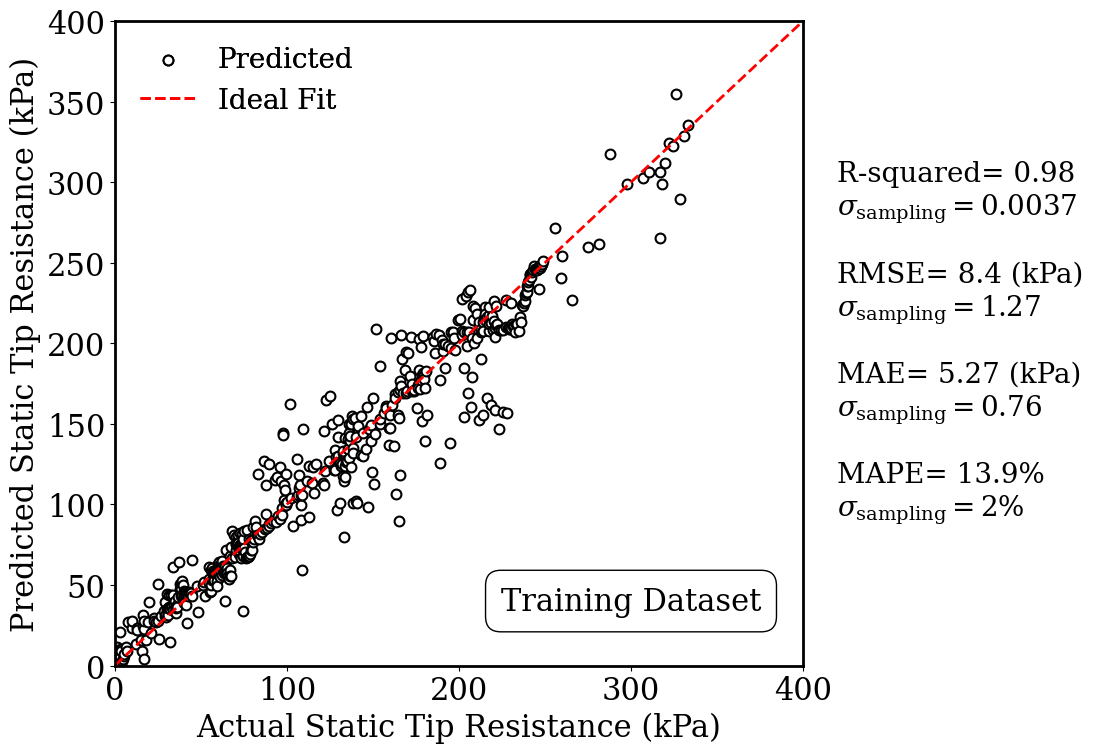

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the uploaded Excel file
file_path = "/content/drive/My Drive/Objective1/train_actual_vs_pred_ANN.xlsx"  # Replace with your file path
xls = pd.ExcelFile(file_path)

# Initialize a list to store data frames from all sheets
data_frames = []

# Iterate through each sheet and extract the actual and predicted columns
for sheet in xls.sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet)
    if 'Actual' in df.columns and 'Predicted' in df.columns:
        data_frames.append(df[['Actual', 'Predicted']])

# Concatenate all data frames into a single DataFrame
combined_df = pd.concat(data_frames)

# Group by 'Actual' values and calculate the mean of corresponding 'Predicted' values
grouped_df = combined_df.groupby('Actual').agg({'Predicted': 'mean'}).reset_index()

# Set the font and size for the plot
plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams["font.size"] = 22
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# Plot Actual vs Mean Predicted values
plt.figure(figsize=(11.5, 8))  # Set the figure size
plt.scatter(grouped_df['Actual'], grouped_df['Predicted'], color='white', edgecolor='black', s=50, label='Predicted', linewidth=1.5)
plt.plot([0, 400], [0, 400], 'r--', lw=2, label='Ideal Fit')  # Extended line to 400

# Set limits for axes
plt.xlim(0, 400)  # Set limits for x-axis
plt.ylim(0, 400)  # Set limits for y-axis

# Set axis labels
plt.xlabel('Actual Static Tip Resistance (kPa)')
plt.ylabel('Predicted Static Tip Resistance (kPa)')

# Customize plot border (spines) to make them thicker and black
ax = plt.gca()  # Get current Axes
ax.spines['top'].set_color('black')
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_color('black')
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(2)

# Add the "Training Dataset" label with a box around it
plt.text(0.75, 0.1, 'Training Dataset', fontsize=22, ha='center', va='center',
         transform=ax.transAxes,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Define the metrics (update these values based on your analysis)
metrics = '\n'.join([
    'R-squared= 0.98',
    '$\sigma_{\mathrm{sampling}} = 0.0037$',
    '',
    'RMSE= 8.4 (kPa)',
    '$\sigma_{\mathrm{sampling}} = 1.27$',
    '',
    'MAE= 5.27 (kPa)',
    '$\sigma_{\mathrm{sampling}} = 0.76$',
    '',
    'MAPE= 13.9%',
    '$\sigma_{\mathrm{sampling}} = 2\%$'
])

# Place the metrics text outside the right border of the plot
plt.text(1.05, 0.5, metrics, transform=ax.transAxes, fontsize=20, verticalalignment='center', horizontalalignment='left')

# First legend for "Predicted" and "Ideal Fit"
legend1 = plt.legend(loc='upper left', frameon=False, fontsize=20)  # Set frameon to False
plt.gca().add_artist(legend1)  # Add the first legend manually to the current axes

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the uploaded Excel file
file_path = "/content/drive/My Drive/Objective1/ANN/test_actual_vs_pred_ss.xlsx"
xls = pd.ExcelFile(file_path)

# Initialize a list to store data frames from all sheets
data_frames = []

# Iterate through each sheet and extract the actual and predicted columns
for sheet in xls.sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet)
    if 'Actual' in df.columns and 'Predicted' in df.columns:
        data_frames.append(df[['Actual', 'Predicted']])

# Concatenate all data frames into a single DataFrame
combined_df = pd.concat(data_frames)

# Group by 'Actual' values and calculate the mean of corresponding 'Predicted' values
grouped_df = combined_df.groupby('Actual').agg({'Predicted': 'mean'}).reset_index()

# Set the font and size for the plot
plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams["font.size"] = 22
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# Plot Actual vs Mean Predicted values
plt.figure(figsize=(12, 8))  # Set the figure size
plt.scatter(grouped_df['Actual'], grouped_df['Predicted'], color='white', edgecolor='black', s=50, label='Predicted', linewidth=1.5)
plt.plot([0, 400], [0, 400], 'r--', lw=2, label='Ideal Fit')  # Extended line to 400

# Set limits for axes
plt.xlim(0, 400)  # Set limits for x-axis
plt.ylim(0, 400)  # Set limits for y-axis

# Set axis labels
plt.xlabel('Actual Static Tip Resistance (kPa)')
plt.ylabel('Predicted Static Tip Resistance (kPa)')

# Customize plot border (spines) to make them thicker and black
ax = plt.gca()  # Get current Axes
ax.spines['top'].set_color('black')
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_color('black')
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(2)

# Add the "Training Dataset" label with a box around it
plt.text(0.75, 0.1, 'Testing Dataset', fontsize=22, ha='center', va='center',
         transform=ax.transAxes,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Define the metrics (update these values based on your analysis)
metrics = '\n'.join([
    'R-squared= 0.92',
    '$\sigma_{\mathrm{sampling}} = 0.025$',
    '',
    'RMSE= 21.97 (kPa)',
    '$\sigma_{\mathrm{sampling}} = 2.59$',
    '',
    'MAE= 12.04 (kPa)',
    '$\sigma_{\mathrm{sampling}} = 1.51$',
    '',
    'MAPE= 26.7%',
    '$\sigma_{\mathrm{sampling}} = 8.9\%$'
])

# Place the metrics text outside the right border of the plot
plt.text(1.05, 0.5, metrics, transform=ax.transAxes, fontsize=20, verticalalignment='center', horizontalalignment='left')

# First legend for "Predicted" and "Ideal Fit"
legend1 = plt.legend(loc='upper left', frameon=False, fontsize=20)  # Set frameon to False
plt.gca().add_artist(legend1)  # Add the first legend manually to the current axes

# Show the plot
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/Objective1/ANN/test_actual_vs_pred_ss.xlsx'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the uploaded Excel file
file_path = "/content/drive/My Drive/Objective1/train_actual_vs_pred_ANN.xlsx"  # Replace with your file path
xls = pd.ExcelFile(file_path)

# Initialize a list to store data frames from all sheets
data_frames = []

# Iterate through each sheet and extract the actual and predicted columns
for sheet in xls.sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet)
    if 'Actual' in df.columns and 'Predicted' in df.columns:
        data_frames.append(df[['Actual', 'Predicted']])

# Concatenate all data frames into a single DataFrame
combined_df = pd.concat(data_frames)

# Sort by 'Actual' values
combined_df = combined_df.sort_values(by='Actual').reset_index(drop=True)

# Set the font and size for the plot
plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams["font.size"] = 22
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# Plot Actual vs Predicted values with data index on x-axis
plt.figure(figsize=(11.5, 8))  # Set the figure size
plt.scatter(combined_df.index, combined_df['Predicted'], facecolor='none', edgecolor='red', s=50, label='Predicted Mean', linewidth=0.1)
plt.scatter(combined_df.index, combined_df['Actual'], facecolor='none', edgecolor='black', s=50, label='Actual Values', linewidth=0.01)

# Set axis labels
plt.xlabel('Data Index')
plt.ylabel('Static Tip Resistance (kPa)')

# Customize plot border (spines) to make them thicker and black
ax = plt.gca()  # Get current Axes
ax.spines['top'].set_color('black')
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_color('black')
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(2)

# Add the "Training Dataset" label with a box around it
plt.text(0.75, 0.1, 'Training Dataset', fontsize=22, ha='center', va='center',
         transform=ax.transAxes,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Define the metrics (update these values based on your analysis)
metrics = '\n'.join([
    'R-squared= 0.98',
    '$\sigma_{\mathrm{sampling}} = 0.0037$',
    '',
    'RMSE= 8.4 (kPa)',
    '$\sigma_{\mathrm{sampling}} = 1.27$',
    '',
    'MAE= 5.27 (kPa)',
    '$\sigma_{\mathrm{sampling}} = 0.76$',
    '',
    'MAPE= 13.9%',
    '$\sigma_{\mathrm{sampling}} = 2\%$'
])

# Place the metrics text outside the right border of the plot
plt.text(1.05, 0.5, metrics, transform=ax.transAxes, fontsize=20, verticalalignment='center', horizontalalignment='left')

# First legend for "Actual" and "Predicted"
legend1 = plt.legend(loc='upper left', frameon=False, fontsize=20)  # Set frameon to False
plt.gca().add_artist(legend1)  # Add the first legend manually to the current axes

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the uploaded Excel file
file_path = "/content/drive/My Drive/Objective1/ANN/test_actual_vs_pred_ss.xlsx"  # Replace with your file path
xls = pd.ExcelFile(file_path)

# Initialize a list to store data frames from all sheets
data_frames = []

# Iterate through each sheet and extract the actual and predicted columns
for sheet in xls.sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet)
    if 'Actual' in df.columns and 'Predicted' in df.columns:
        data_frames.append(df[['Actual', 'Predicted']])

# Concatenate all data frames into a single DataFrame
combined_df = pd.concat(data_frames)

# Sort by 'Actual' values
combined_df = combined_df.sort_values(by='Actual').reset_index(drop=True)

# Set the font and size for the plot
plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams["font.size"] = 22
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# Plot Actual vs Predicted values with data index on x-axis
plt.figure(figsize=(11.5, 8))  # Set the figure size
plt.scatter(combined_df.index, combined_df['Predicted'], facecolor='none', edgecolor='red', s=50, label='Predicted Mean', linewidth=0.1)
plt.scatter(combined_df.index, combined_df['Actual'], facecolor='none', edgecolor='black', s=50, label='Actual Values', linewidth=0.01)

# Set axis labels
plt.xlabel('Data Index')
plt.ylabel('Static Tip Resistance (kPa)')

# Customize plot border (spines) to make them thicker and black
ax = plt.gca()  # Get current Axes
ax.spines['top'].set_color('black')
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_color('black')
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(2)

# Add the "Training Dataset" label with a box around it
plt.text(0.75, 0.1, 'Training Dataset', fontsize=22, ha='center', va='center',
         transform=ax.transAxes,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Define the metrics (update these values based on your analysis)
metrics = '\n'.join([
    'R-squared= 0.98',
    '$\sigma_{\mathrm{sampling}} = 0.0037$',
    '',
    'RMSE= 8.4 (kPa)',
    '$\sigma_{\mathrm{sampling}} = 1.27$',
    '',
    'MAE= 5.27 (kPa)',
    '$\sigma_{\mathrm{sampling}} = 0.76$',
    '',
    'MAPE= 13.9%',
    '$\sigma_{\mathrm{sampling}} = 2\%$'
])

# Place the metrics text outside the right border of the plot
plt.text(1.05, 0.5, metrics, transform=ax.transAxes, fontsize=20, verticalalignment='center', horizontalalignment='left')

# First legend for "Actual" and "Predicted"
legend1 = plt.legend(loc='upper left', frameon=False, fontsize=20)  # Set frameon to False
plt.gca().add_artist(legend1)  # Add the first legend manually to the current axes

# Show the plot
plt.tight_layout()
plt.show()